In [1]:
#Import Library
from torchvision import datasets
import torchvision.transforms as transforms
import collections
from torchvision import utils
from torch.utils.data import DataLoader
from torchsummary import summary
from torch import nn
from torch import optim
import torch
import torchvision
import matplotlib.pyplot as plt

# pytorch 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
image_directory = r'D:\Magister Program\Master Computer Science\Semester 2\Deep Learning\Session 2\Session 2\vegetable_images'

#preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  #resize images
    transforms.ToTensor(),   # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))        
])


# Create ImageFolder datasets
train_dataset = datasets.ImageFolder(root='vegetable_images/train', transform=transform)
val_dataset = datasets.ImageFolder(root='vegetable_images/validation', transform=transform)
test_dataset = datasets.ImageFolder(root='vegetable_images/test', transform=transform)

# Create a data loader
batch_size = 64  # membagi dataset menjadi 32 bagian
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
dataset = train_loader.dataset

# Check if the dataset has the 'classes' attribute
if hasattr(dataset, 'classes'):
    # Print the class labels
    print(dataset.classes)
else:
    print("The dataset does not have a 'classes' attribute")

['Broccoli', 'Cabbage', 'Cauliflower']


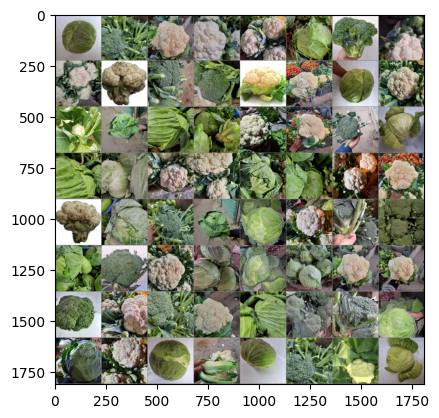

Cabbage Broccoli Cauliflower Cauliflower Cauliflower Cabbage Broccoli Cauliflower Cauliflower Cauliflower Broccoli Broccoli Cauliflower Cauliflower Cabbage Cauliflower Cauliflower Cabbage Cabbage Cabbage Cauliflower Cauliflower Broccoli Cabbage Cabbage Cabbage Cauliflower Cauliflower Cabbage Cabbage Cauliflower Cauliflower Cauliflower Cabbage Broccoli Cabbage Cabbage Cauliflower Broccoli Broccoli Cabbage Broccoli Cauliflower Cabbage Cabbage Cabbage Cauliflower Cauliflower Broccoli Cauliflower Broccoli Cauliflower Cabbage Broccoli Broccoli Cabbage Cabbage Cauliflower Cabbage Cauliflower Cabbage Broccoli Cauliflower Cabbage


In [5]:
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{train_dataset.classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
print(f'Number of training images: {len(train_dataset)}')
print(f'Number of validation images: {len(val_dataset)}')
print(f'Number of test images: {len(test_dataset)}')

Number of training images: 3000
Number of validation images: 600
Number of test images: 600


In [7]:
from collections import Counter
for i in [train_dataset, test_dataset, val_dataset]:
    print(dict(Counter(i.targets)))

{0: 1000, 1: 1000, 2: 1000}
{0: 200, 1: 200, 2: 200}
{0: 200, 1: 200, 2: 200}


## Modelling

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the convolution layers
        self.conv1 = nn.Conv2d(3, 16, 3, padding=0) # Output: (224 - 3 + 2*0)/1 + 1 = 222
        self.pool = nn.MaxPool2d(2, 2)              # Output: 222 / 2 = 111
        self.conv2 = nn.Conv2d(16, 32, 3, padding=0) # Output: (111 - 3 + 2*0)/1 + 1 = 109
        self.conv3 = nn.Conv2d(32, 32, 3, padding=0) # Output: (109 - 3 + 2*0)/1 + 1 = 107
        self.conv4 = nn.Conv2d(32, 64, 3, padding=0) # Output: (107 - 3 + 2*0)/1 + 1 = 105
        self.pool2 = nn.MaxPool2d(2, 2)             # Output: 105 / 2 = 52 (rounded down)

        # Calculate the size of the flattened features after last pooling
        feature_size = 64 * 52 * 52  #flatten for fully connected

        # Define the fully connected layers
        self.fc1 = nn.Linear(feature_size, 100)
        self.dropout1 = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(100, 80)
        self.fc3 = nn.Linear(80, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool2(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except the batch
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout1(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x
    
net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(net.parameters(), lr=0.0001)

In [9]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

In [10]:
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(20):  # loop over the dataset multiple times
    net.train()
    running_loss, running_acc = 0.0, 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += calculate_accuracy(outputs, labels)
    train_losses.append(running_loss / len(train_loader))
    train_accs.append(running_acc / len(train_loader))

    net.eval()
    val_loss, val_acc = 0.0, 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += calculate_accuracy(outputs, labels)
            _, preds = torch.max(outputs, 1)  
            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())  
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_acc / len(val_loader))
    

    print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.2f}, Train Acc: {train_accs[-1]:.2f}, Val Loss: {val_losses[-1]:.2f}, Val Acc: {val_accs[-1]:.2f}')

Epoch 1, Train Loss: 1.02, Train Acc: 0.50, Val Loss: 0.84, Val Acc: 0.73
Epoch 2, Train Loss: 0.84, Train Acc: 0.72, Val Loss: 0.75, Val Acc: 0.82
Epoch 3, Train Loss: 0.75, Train Acc: 0.82, Val Loss: 0.66, Val Acc: 0.90
Epoch 4, Train Loss: 0.70, Train Acc: 0.87, Val Loss: 0.64, Val Acc: 0.91
Epoch 5, Train Loss: 0.67, Train Acc: 0.89, Val Loss: 0.64, Val Acc: 0.91
Epoch 6, Train Loss: 0.66, Train Acc: 0.90, Val Loss: 0.63, Val Acc: 0.92
Epoch 7, Train Loss: 0.64, Train Acc: 0.92, Val Loss: 0.61, Val Acc: 0.94
Epoch 8, Train Loss: 0.63, Train Acc: 0.93, Val Loss: 0.61, Val Acc: 0.94
Epoch 9, Train Loss: 0.62, Train Acc: 0.94, Val Loss: 0.60, Val Acc: 0.95
Epoch 10, Train Loss: 0.62, Train Acc: 0.93, Val Loss: 0.60, Val Acc: 0.95
Epoch 11, Train Loss: 0.61, Train Acc: 0.95, Val Loss: 0.60, Val Acc: 0.95
Epoch 12, Train Loss: 0.61, Train Acc: 0.95, Val Loss: 0.61, Val Acc: 0.94
Epoch 13, Train Loss: 0.60, Train Acc: 0.96, Val Loss: 0.59, Val Acc: 0.96
Epoch 14, Train Loss: 0.60, Train 

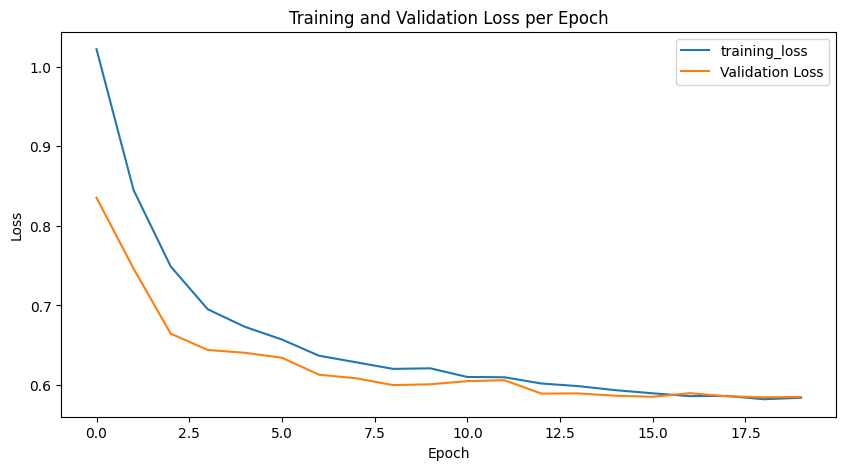

In [11]:
import matplotlib.pyplot as plt
# Plot training dan validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label = 'training_loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

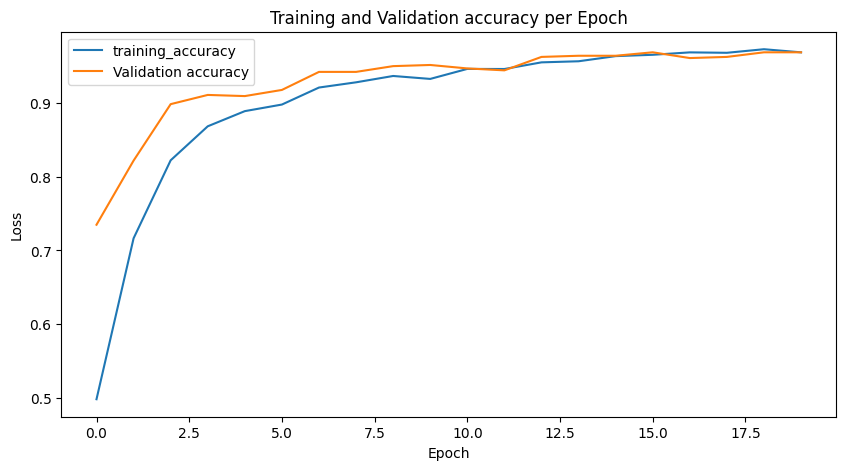

In [12]:
# Plot training dan validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label = 'training_accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.title('Training and Validation accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
def calculate_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    return f1, cm

In [14]:
f1, cm = calculate_metrics(all_labels, all_preds)
print(f'Validation F1 Score: {f1:.2f}')
print('Confusion Matrix:')
print(cm)

Validation F1 Score: 0.97
Confusion Matrix:
[[193   3   4]
 [  6 194   0]
 [  1   6 193]]


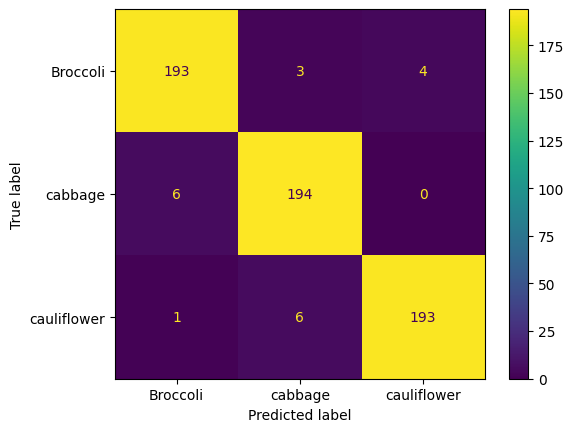

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['Broccoli',  "cabbage", "cauliflower"])
disp.plot()
plt.show()

In [16]:
from sklearn.metrics import classification_report
report = classification_report(all_labels, all_preds, target_names=["broccoli", "cabbage", "cauliflower"])
print(report)

              precision    recall  f1-score   support

    broccoli       0.96      0.96      0.96       200
     cabbage       0.96      0.97      0.96       200
 cauliflower       0.98      0.96      0.97       200

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



In [17]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradients needed
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total
    print(f'Test Loss: {avg_loss:.2f}, Test Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy

In [18]:
evaluate_model(net, test_loader, criterion)

Test Loss: 0.60, Test Accuracy: 0.95%


(0.5971321642398835, 0.9533333333333334)

In [19]:
# torch.save(net.state_dict(), 'latest_weight_project.pth')  #save the model has been trained

## Model Inference

In [20]:
# # import torch.nn as nn
# # import torch.nn.functional as F
# # import torch.optim as optim


# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # Define the convolution layers
#         self.conv1 = nn.Conv2d(3, 16, 3)            # Output: (224 - 3 + 2*0)/1 + 1 = 222
#         self.pool = nn.MaxPool2d(2, 2)              # Output: 222 / 2 = 111
#         self.conv2 = nn.Conv2d(16, 32, 3)           # Output: (111 - 3 + 2*0)/1 + 1 = 109
#         self.conv3 = nn.Conv2d(32, 32, 3)           # Output: (109 - 3 + 2*0)/1 + 1 = 107
#         self.conv4 = nn.Conv2d(32, 64, 3)           # Output: (107 - 3 + 2*0)/1 + 1 = 105
#         self.pool2 = nn.MaxPool2d(2, 2)             # Output: 105 / 2 = 52 (rounded down)

#         # Calculate the size of the flattened features after last pooling
#         feature_size = 64 * 52 * 52

#         # Define the fully connected layers
#         self.fc1 = nn.Linear(feature_size, 100)
#         self.dropout1 = nn.Dropout(p=0.4)
#         self.fc2 = nn.Linear(100, 80)
#         self.fc3 = nn.Linear(80, 3)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
#         x = self.pool2(F.relu(self.conv4(x)))
#         x = torch.flatten(x, 1)  # flatten all dimensions except the batch
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)
#         x = F.relu(self.fc2(x))
#         x = self.dropout1(x)
#         x = self.fc3(x)
#         x = F.softmax(x, dim=1)
#         return x

In [21]:
# params = summary(net, (3, 224, 224))

In [22]:
# #Write your code for inference here
# from PIL import Image

# model = Net()

# # Load the weights
# state_dict = torch.load('224_dropout2.pth')
# model.load_state_dict(state_dict)

# # Switch to evaluation mode
# model.eval()

# # Now you can use model to perform inference
# # Load and prepare the image
# image_path = r'D:\Magister Program\Master Computer Science\Semester 2\Deep Learning\Session 2\Session 2\vegetable_images\train\Broccoli\0020.jpg'
# input_image = Image.open(image_path)


# # Define the same transforms that were used during the model training
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize to the input size of the model
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
# ])

# # Apply the transforms to the image
# input_tensor = transform(input_image)
# input_batch = input_tensor.unsqueeze(0)  

# # Move the input and model to GPU for speed if available
# if torch.cuda.is_available():
#     input_batch = input_batch.to('cuda')
#     model.to('cuda')

# with torch.no_grad():
#     output = model(input_batch)

# # Convert output logits to predicted class (index) and probabilities
# probabilities = torch.nn.functional.softmax(output[0], dim=0)
# max_value, predicted_class = torch.max(probabilities, 0)
# classes = ('broccoli', 'cabbage', 'cauliflower')

# # Print the result
# class_name = classes[predicted_class.item()]
# # print(f"Predicted label name: {class_name}")
# print(f'Predicted label: {class_name}, confidence: {max_value.item() * 100:.2f}%')

# # Show the input image
# plt.imshow(input_image)
# plt.title(f'Predicted label: {class_name}, confidence: {max_value.item() * 100:.2f}%')
# plt.show()